In [ ]:
!apt-get install gcc-4.8 gcc-5 g++-4.8 g++-5
!apt-get install libblas-dev liblapack-dev
!apt-get install libopenblas-dev
!apt-get install gfortran-4.8
!apt-get install gfortran-5
!apt-get install scons
!apt-get install libpng-dev
!apt-get install libboost-all-dev freeglut3-dev
!apt-get install xvfb

In [ ]:
!pip install torch==1.3.0

In [2]:
!update-alternatives --install /usr/bin/gcc gcc /usr/bin/gcc-4.8 10
!update-alternatives --install /usr/bin/gcc gcc /usr/bin/gcc-5 20
!update-alternatives --install /usr/bin/g++ g++ /usr/bin/g++-4.8 10
!update-alternatives --install /usr/bin/g++ g++ /usr/bin/g++-5 20

In [ ]:
!git clone https://github.com/mszarski/diffsim.git

In [4]:
!chmod +x diffsim/arcsim/dependencies/taucs/configure

In [ ]:
%cd /content

In [ ]:
%cd diffsim
!update-alternatives --set gcc "/usr/bin/gcc-4.8"
!update-alternatives --set g++ "/usr/bin/g++-4.8"
%cd arcsim/dependencies/
!make 
%cd ../..
!update-alternatives --set gcc "/usr/bin/gcc-5"
!update-alternatives --set g++ "/usr/bin/g++-5"
!make -j 8
%cd pysim
!ln -s ../arcsim/conf ./conf
!ln -s ../arcsim/materials ./materials
!ln -s ../arcsim/meshes ./meshes


In [1]:
##restart runtime here

In [3]:
%cd /content/diffsim/pysim

/content/diffsim/pysim


In [2]:
from google.colab import drive
from os.path import join

ROOT = '/content/drive'     # default for the drive
PROJ = 'My Drive/draping_workspace'       # path to your project on Drive

drive.mount(ROOT)

Mounted at /content/drive


In [4]:
%%writefile conf/draping.json
{
    "frame_time": 0.125,
    "frame_steps": 1,
    "end_time": 10,
    "cloths": [
    {
        "mesh": "/content/drive/My Drive/draping_workspace/2d_shape_flatmesh.obj",
        "transform":{"scale":0.01,"translate":[-0.1,-0.3,0.3]},
        "materials": [{"data": "materials/gray-interlock.json",
                       "thicken": 2}],
        "remeshing": {
            "refine_angle": 0.3,
            "refine_compression": 0.005,
            "refine_velocity": 0.5,
            "size": [10e-3, 100e-3],
            "aspect_min": 0.2
        }
    }
    ],
    "obstacles": [
    {
        "mesh": "/content/drive/My Drive/draping_workspace/3d_shape.obj",
        "transform":{"scale":0.01,"translate":[-0.1,-0.3,-0.5]},
        "velocity": [0, 0, 0, 0, 0, 0],
        "movable": 0
    }
    ],
    "disable":["remeshing", "proximity"],
    "handles": [{"nodes": [302, 198, 2, 23]}],
    "gravity":[0, 0, -2],
    "magic": {"repulsion_thickness": 5e-3, "collision_stiffness": 1e6}
}

Overwriting conf/draping.json


In [6]:
!rm -rf /content/default_out

In [7]:
import torch
import arcsim
import gc
import time
import json
#import sysx
import gc
import os
import numpy as np

from datetime import datetime
now = datetime.now()
timestamp = datetime.now().strftime('%Y-%m-%d_%H:%M:%S')

out_path = '/content/default_out'

if not os.path.exists(out_path):
	os.mkdir(out_path)

with open('conf/draping.json','r') as f:
	config = json.load(f)

def save_config(config, file):
	with open(file,'w') as f:
		json.dump(config, f)

save_config(config, out_path+'/conf.json')

torch.set_num_threads(8)
spf = config['frame_steps']
scalev=1

pre_steps = 10
steps=30
epochs=25

seed_point_index = 292
handles = [302, 198, 2, 23]
boundary = [  2,   1,  68,  74,  77,  79,  81,  83,  85,  87,  89, 198,  65, 
         63,  61,  59,  57,  55,  53,  51,  49,  47,  45,  43,  41,  39,
         37,  35,  33,  31,  29,  27,  25,  24,  23,  21,  19,  17,  15,
         13,  11,   9,   7,   4,   3, 302,  92,  91,  95,  98,  97, 101,
        103, 105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127,
        129, 131, 133, 139, 141,   0]

def reset_sim(sim, epoch):
	if epoch < epochs:
		arcsim.init_physics(out_path+'/conf.json', out_path+'/out%d'%epoch,False)
	else:
		arcsim.init_physics(out_path+'/conf.json',out_path+'/out',False)

def run_sim(steps,sim,param_v):

	loss = 0.

	print("step")
	for step in range(pre_steps + steps):
		print(step)
	
		if step > pre_steps:
			for i in range(len(handles)):
				sim.cloths[0].mesh.nodes[handles[i]].v += param_v[step-pre_steps,i] * spf

		# from IPython.core.debugger import set_trace
		# set_trace()

		print(sim.obstacles[0].curr_state_mesh.nodes[seed_point_index].x - sim.cloths[0].mesh.nodes[seed_point_index].x)
	  
		loss_idxs = [*boundary]
		#loss_idxs = [*handles]
		#loss_idxs = [seed_point_index, *handles, *flattening_line]
		#loss_idxs = list(range(len(sim.cloths[0].mesh.nodes)))

		if step > pre_steps:
			for i in loss_idxs:
				loss += torch.norm(sim.obstacles[0].curr_state_mesh.nodes[i].x - sim.cloths[0].mesh.nodes[i].x, p=1) #* (1 + ((step-pre_steps)/steps))
				# dist = torch.norm(sim.obstacles[0].curr_state_mesh.nodes[i].x - sim.cloths[0].mesh.nodes[i].x, p=2)
				# loss += torch.log(dist+0.001) * (1 + ((step-pre_steps)/steps))
		
		arcsim.sim_step()
	
	#loss /= (len(loss_idxs) * steps)

	v_limit = 0.5 #was 0.25
	stiffness = 2
	weight = 2/30 * steps * 1/7 * len(loss_idxs)
	v_constraint = torch.sum(weight / (1.0+torch.exp(stiffness*(1.0 - (torch.abs(param_v)/v_limit)))))

	avg = torch.mean(param_v,dim=1,keepdim=True)
	reg = (torch.norm(param_v-avg, dim=2)**2).mean()

	total_loss = loss + v_constraint + reg

	return total_loss

def do_train(cur_step,optimizer,scheduler,sim,param_v):
	epoch = 0
	while True:
		reset_sim(sim, epoch)
		st = time.time()
		loss = run_sim(steps, sim, param_v)
		en0 = time.time()
		optimizer.zero_grad()
	
		loss.backward(retain_graph=True)

		en1 = time.time()
		print("=======================================")
		#print(param_v.data)
		#print(param_v.grad.data)
		f.write('epoch {}:  loss={} \n'.format(epoch,  loss.data))
		print('epoch {}:  loss={} \n'.format(epoch, loss.data))

		print('forward time={}'.format(en0-st))
		print('backward time={}'.format(en1-en0))

		param_v.grad.data.clamp_(-25,25)

		optimizer.step()
	
		arcsim.delete_mesh(sim.cloths[0].mesh)

		scheduler.step(loss.item())

		if epoch>=epochs:
			break
		epoch = epoch + 1

with open(out_path+('/log%s.txt'%timestamp),'w',buffering=1) as f:
	tot_step = 1
	sim=arcsim.get_sim()
	# reset_sim(sim)

	param_v = torch.zeros([steps, 4,3],dtype=torch.float64, requires_grad=True)

	#lr = 0.1 *1000 * 7
	lr = 0.01
	momentum = 0.4
	f.write('lr={} momentum={}\n'.format(lr,momentum))

	optimizer = torch.optim.Adam([param_v],lr=0.025)
	scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=0, verbose=True)

	for cur_step in range(tot_step):
		do_train(cur_step,optimizer,scheduler,sim,param_v)

print("done")


step
0
tensor([-2.6488e-04, -1.1538e-02, -5.7818e-01], dtype=torch.float64)
1
tensor([-2.6488e-04, -1.1538e-02, -5.4693e-01], dtype=torch.float64,
       grad_fn=<SubBackward0>)
2
tensor([-3.1125e-04, -1.1494e-02, -4.8704e-01], dtype=torch.float64,
       grad_fn=<SubBackward0>)
3
tensor([-0.0013, -0.0113, -0.4055], dtype=torch.float64,
       grad_fn=<SubBackward0>)
4
tensor([-0.0037, -0.0098, -0.3105], dtype=torch.float64,
       grad_fn=<SubBackward0>)
5
tensor([-0.0077, -0.0078, -0.2105], dtype=torch.float64,
       grad_fn=<SubBackward0>)
6
tensor([-0.0114, -0.0075, -0.1235], dtype=torch.float64,
       grad_fn=<SubBackward0>)
7
tensor([-0.0141, -0.0095, -0.0745], dtype=torch.float64,
       grad_fn=<SubBackward0>)
8
tensor([-0.0137, -0.0091, -0.0630], dtype=torch.float64,
       grad_fn=<SubBackward0>)
9
tensor([-0.0125, -0.0091, -0.0708], dtype=torch.float64,
       grad_fn=<SubBackward0>)
10
tensor([-0.0109, -0.0084, -0.0828], dtype=torch.float64,
       grad_fn=<SubBackward0>)

In [33]:
%cd /content/diffsim/pysim

/content/diffsim/pysim


In [19]:
%%writefile visualize.py
import torch
import arcsim

with torch.autograd.profiler.profile() as prof:
	  arcsim.msim(4,['arcsim','replay','/content/default_out/out', '/content/default_out/out'])
print(prof)

Overwriting visualize.py


In [ ]:
!xvfb-run -s "-screen 0 1280x720x24 -ac +extension GLX +render -noreset" python visualize.py

In [21]:
import pathlib
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

frames = []
for bmp_file in sorted(list(pathlib.Path('/content/default_out/out').glob('*.bmp'))):
    frames.append(plt.imread(bmp_file))
    #print(bmp_file)
    

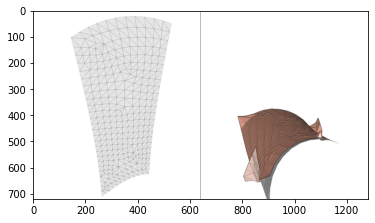

In [22]:
from matplotlib import animation, rc
from IPython.display import HTML

fig = plt.figure()

ims = []
for i in range(len(frames)):
    im = plt.imshow(frames[i], animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

rc('animation', html='jshtml')
ani

In [23]:
HTML(ani.to_html5_video())

In [24]:
print(param_v)

tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 6.2649e-02, -5.6028e-02, -2.1794e-01],
         [-1.6410e-01,  8.0531e-02, -2.3142e-01],
         [ 1.8702e-01,  7.3139e-02, -1.3694e-01],
         [-1.8841e-01, -1.3518e-01, -1.7093e-01]],

        [[ 2.9832e-02, -4.7539e-02, -2.3166e-01],
         [-1.0948e-01,  1.3239e-02, -1.4746e-01],
         [ 1.4678e-01,  1.7897e-01, -1.0287e-01],
         [-1.7817e-01, -6.4787e-02, -2.8079e-01]],

        [[ 1.5641e-03, -4.5197e-02, -2.2381e-01],
         [-2.3824e-02, -1.2664e-03, -1.5989e-01],
         [ 6.7584e-03,  2.2206e-01, -2.2313e-01],
         [-1.8327e-01, -6.3325e-02, -1.8982e-01]],

        [[ 1.7352e-02, -3.1457e-02, -2.3470e-01],
         [-5.7274e-02, -6.5640e-03, -2.2445e-01],
         [ 1.4344e-01,  1.4642e-01, -1.9741e-01],
         [-1.9442e-01, -7.8030e-02, -2.722

In [25]:
ani.save('diffdrape.mp4')

In [26]:
torch.save(param_v, 'trajectory.pt')